In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import zarr
import os 

from test_train import *

def read_zarr_file(file_path, array_or_group_key=None):
    """
    Read and extract data from a .zarr file.

    Parameters:
    - file_path: str, the path to the .zarr file.
    - array_or_group_key: str, optional key specifying which array or group to extract from the Zarr store.

    Returns:
    Zarr array or group, depending on what is stored in the file.
    """
    # Open Zarr file
    root = zarr.open(file_path, mode='r')

    if array_or_group_key is None:
        # Return the root group or array if no key is specified
        return root
    else:
        # Otherwise, return the specified array or group
        return root[array_or_group_key]


def get_lognorm(output_data):
    output_data_mean = np.mean(np.abs(output_data))
    output_data_std = np.std(np.abs(output_data))
    norm_output = colors.LogNorm(vmin=output_data_mean - output_data_std * 0.5 + 1e-10, 
                          vmax=output_data_mean + output_data_std * 2)
    return norm_output

def find_checkpoint(folder):
    subdir = os.path.join(folder, 'checkpoints')
    checkpoint_filepath = os.listdir(subdir)[0]
    return os.path.join(subdir, checkpoint_filepath)
    

# Usage example
file_path = "Mini_R2F.zarr"

# To read the root array or group
root = read_zarr_file(file_path)

# To read a specific array or group
raw = read_zarr_file(file_path, "raw")
gt = read_zarr_file(file_path, "gt")

%load_ext autoreload
%autoreload 2

Using NVIDIA A40-48C for training.


In [13]:
# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and weights
# Load the full checkpoint
checkpoint_file = find_checkpoint("/home/roberto/PythonProjects/SSFocus/Data/FOCUSED/lightning_logs/version_2/")
checkpoint = torch.load(checkpoint_file, map_location=device)
# model = ComplexCNN().to(device)
# model = UNet(2,2).to(device)
model = robertNet(input_shape=(512,512)).to(device)

# If your model was wrapped with a LightningModule, you may need to prepend 'model.' to each key
model.load_state_dict({key.replace('model.', ''): value for key, value in checkpoint['state_dict'].items()})
model.eval()  # Set the model to evaluation mode


robertNet()

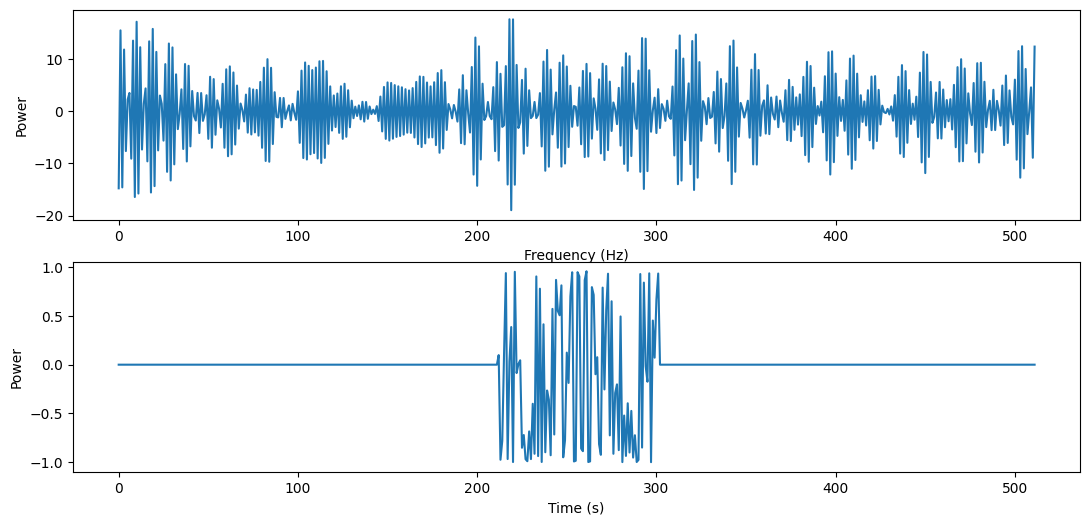

In [14]:
model._plot_rg_filter()

In [15]:
img = raw[0][:512,:512]
rg_comp = model.range_compression(torch.tensor(img).to(device))

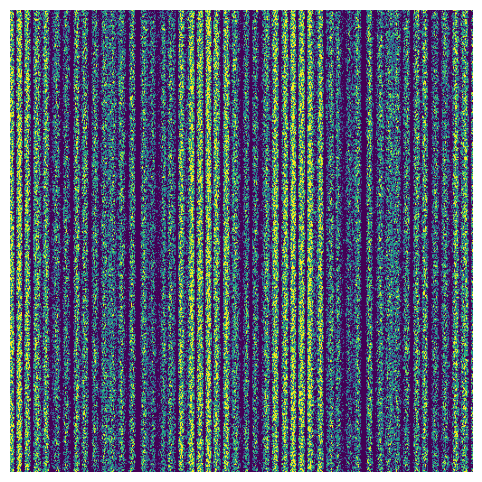

In [16]:
model._plot_tensor(rg_comp)

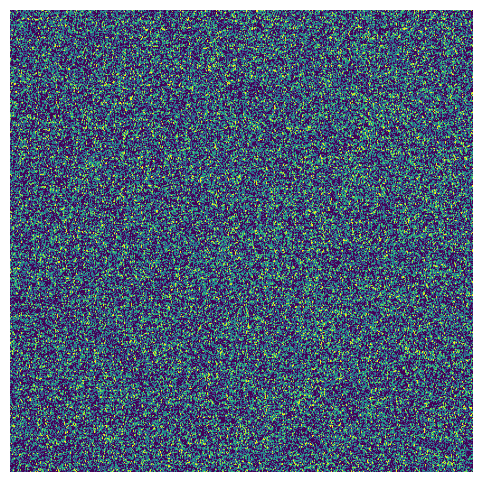

In [17]:
model._plot_tensor(raw[0][:512,:512])

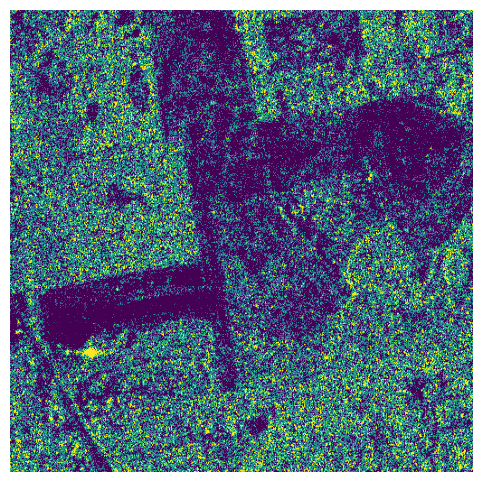

In [18]:
model._plot_tensor(gt[0][:512,:512])

In [19]:
idx = 0
input_tensor = torch.tensor(raw[idx][:512,:512], dtype=torch.complex64).to(device)
# Perform inference
with torch.no_grad():
    output_tensor = model(input_tensor.unsqueeze(0).unsqueeze(0))  # Adding a batch dimension
    output_tensor = output_tensor.squeeze(0).squeeze(0)
    output_tensor = output_tensor.cpu().numpy()  # Removing batch dimension and sending to cpu
    
    


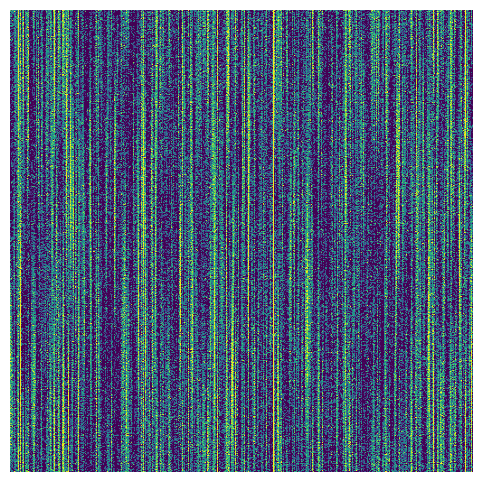

In [20]:
model._plot_tensor(output_tensor)

In [ ]:
from scipy.interpolate import interp1d

idx = 0
input_tensor = torch.tensor(raw[idx][:512,:512], dtype=torch.complex64).to(device)
# Perform inference
with torch.no_grad():
    output_tensor = model(input_tensor.unsqueeze(0).unsqueeze(0))  # Adding a batch dimension
    output_tensor = output_tensor.squeeze(0).squeeze(0)
    output_tensor = output_tensor.cpu().numpy()  # Removing batch dimension and sending to cpu



print('Input tensor shape is:', input_tensor.shape)

# Create figure and plot images
plt.figure(figsize=(15, 15))
# Calculate mean and std for both input and output data
range_start_idx = 0
range_end_idx = range_start_idx + 512


def interpolate_range_filter(original_filter, new_size, method='linear'):
    x = np.linspace(0, len(original_filter) - 1, len(original_filter))
    f = interp1d(x, original_filter, kind=method)
    x_new = np.linspace(0, len(original_filter) - 1, new_size)
    return f(x_new)

fft_filter = model.range_filter_fft
filter = torch.fft.ifft(fft_filter)
rg_filter = interpolate_range_filter(filter.cpu().numpy(), new_size=512, method='zero')
rg_filter = torch.fft.fft(torch.tensor(rg_filter))
rg_compressed = torch.fft.fft(input_tensor) * rg_filter.cuda()

input_tensor = input_tensor.cpu().numpy()
input_data_mean = np.mean(np.abs(input_tensor))
input_data_std = np.std(np.abs(input_tensor))

output_data_mean = np.mean(np.abs(output_tensor))
output_data_std = np.std(np.abs(output_tensor))

gt_data_mean = np.mean(np.abs(gt[idx]))
gt_data_std = np.std(np.abs(gt[idx]))

plt.subplot(2, 2, 1)
plt.title("Input Image")
norm_input = colors.LogNorm(vmin=input_data_mean - input_data_std * 0.5 + 1e-10, vmax=input_data_mean + input_data_std * 2)
plt.imshow(np.abs(input_tensor), cmap='viridis', norm=norm_input)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Input Rg Comppressed")
norm_input = get_lognorm(rg_compressed.cpu().numpy())
plt.imshow(np.abs(rg_compressed.cpu()), cmap='viridis', norm=norm_input)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Output Image")
norm_output = colors.LogNorm(vmin=output_data_mean - output_data_std * 0.5 + 1e-10, vmax=output_data_mean + output_data_std * 2)
plt.imshow(np.abs(output_tensor), cmap='viridis', norm=norm_output)
# plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("GT Image")
norm_output = colors.LogNorm(vmin=gt_data_mean - gt_data_std * 0.5 + 1e-10, vmax=gt_data_mean + gt_data_std * 2)
plt.imshow(np.abs(gt[idx][:512,:512]), cmap='viridis', norm=norm_output)
# plt.axis('off')
plt.show()

In [ ]:
range_start_idx = 1000
range_end_idx = range_end_idx + 512
y = model.range_filter_fft[:]

y = torch.fft.ifft(y)

plt.figure(figsize=(15, 5))
plt.plot(y.cpu().numpy().real)
plt.xlim([10000,16000])

In [ ]:
az_filter = model.az_filter

In [ ]:
az = az_filter.detach().cpu().numpy()

In [ ]:
plt.plot(az[0].real)

In [ ]:
plt.plot(az[1].real)


In [ ]:
def check_rows_identical(matrix):
    return np.all(matrix == matrix[0, :])

def check_columns_identical(matrix):
    return np.all(matrix == matrix[:, 0][:, None])

print(check_rows_identical(az))
print(check_columns_identical(az))

In [ ]:
# # Load new radar data for inference
# # idx = 0
# # new_radar_data = raw[idx]

# new_radar_data = np.load('/home/roberto/PythonProjects/SSFocus/Data/FOCUSED/radar_data_ifft_numpy.npy','r')

# # Convert to PyTorch tensor and send to the same device as the model
# input_tensor = torch.tensor(new_radar_data, dtype=torch.complex64).to(device)

# # Convert the image to PyTorch tensor
# real_part = input_tensor.real.unsqueeze(0)
# imag_part = input_tensor.imag.unsqueeze(0)

# scale_factor = 0.2

# resized_real_part = F.interpolate(real_part.unsqueeze(0), scale_factor=scale_factor, mode='bilinear', align_corners=False).squeeze(0)
# resized_imag_part = F.interpolate(imag_part.unsqueeze(0), scale_factor=scale_factor, mode='bilinear', align_corners=False).squeeze(0)
# input_tensor = torch.complex(resized_real_part.squeeze(0), resized_imag_part.squeeze(0))

# # Perform inference
# with torch.no_grad():
#     output_tensor = model(input_tensor.unsqueeze(0))  # Adding a batch dimension
#     output_tensor = output_tensor.squeeze(0)
#     r, i = output_tensor[0], output_tensor[1]
#     output_tensor = torch.complex(r, i).cpu().numpy()  # Removing batch dimension and sending to cpu


# # Calculate mean and std for both input and output data
# input_data_mean = np.mean(np.abs(new_radar_data))
# input_data_std = np.std(np.abs(new_radar_data))

# output_data_mean = np.mean(np.abs(output_tensor))
# output_data_std = np.std(np.abs(output_tensor))

# gt_data_mean = np.mean(np.abs(gt[idx]))
# gt_data_std = np.std(np.abs(gt[idx]))

# # Create figure and plot images
# plt.figure(figsize=(15, 15))

# plt.subplot(1, 3, 1)
# plt.title("Input Image")
# norm_input = colors.LogNorm(vmin=input_data_mean - input_data_std * 0.5 + 1e-10, vmax=input_data_mean + input_data_std * 2)
# plt.imshow(np.abs(new_radar_data), cmap='viridis', norm=norm_input)
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title("Output Image")
# norm_output = colors.LogNorm(vmin=output_data_mean - output_data_std * 0.5 + 1e-10, vmax=output_data_mean + output_data_std * 2)
# plt.imshow(np.abs(output_tensor), cmap='viridis', norm=norm_output)
# # plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title("GT Image")
# norm_output = colors.LogNorm(vmin=gt_data_mean - gt_data_std * 0.5 + 1e-10, vmax=gt_data_mean + gt_data_std * 2)
# plt.imshow(np.abs(gt[idx]), cmap='viridis', norm=norm_output)
# # plt.axis('off')

# plt.show()

In [ ]:
# plt.figure(figsize=(20, 20))
# plt.title("Output Image")
# norm_output = colors.LogNorm(vmin=output_data_mean - output_data_std * 0.5 + 1e-10, vmax=output_data_mean + output_data_std * 2)
# plt.imshow(np.abs(output_tensor), cmap='viridis', norm=norm_output)
# plt.axis('off')
